# Part 4: Quantization

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2025-05-21 15:42:52.638635: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 15:42:52.663756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 15:42:52.663780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 15:42:52.663785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 15:42:52.667914: I tensorflow/core/platform/cpu_feature_g

## Fetch the jet tagging dataset from Open ML

In [2]:
#X_train_val = np.load('X_train_val.npy')
#X_test = np.load('X_test.npy')
#y_train_val = np.load('y_train_val.npy')
#y_test = np.load('y_test.npy')
#classes = np.load('classes.npy', allow_pickle=True)

n_samples = 1000
X_train_val = np.random.rand(n_samples, 32, 32, 1).astype("float64")
y_train_val = X_train_val.copy().astype("float32")  # auto-encoder target is the input itself
X_test = np.random.rand(n_samples, 32, 32, 1).astype("float64")
y_test = X_test.copy().astype("float32")  # auto-encoder target is the input itself

print(X_train_val.shape, y_train_val.shape)
print(X_train_val.dtype, y_train_val.dtype)
print(X_train_val[0:5])
print(y_train_val[0:5])

(1000, 32, 32, 1) (1000, 32, 32, 1)
float64 float32
[[[[0.5488135 ]
   [0.71518937]
   [0.60276338]
   ...
   [0.41466194]
   [0.26455561]
   [0.77423369]]

  [[0.45615033]
   [0.56843395]
   [0.0187898 ]
   ...
   [0.11037514]
   [0.65632959]
   [0.13818295]]

  [[0.19658236]
   [0.36872517]
   [0.82099323]
   ...
   [0.7163272 ]
   [0.28940609]
   [0.18319136]]

  ...

  [[0.77311005]
   [0.21687025]
   [0.90314965]
   ...
   [0.52217587]
   [0.85360604]
   [0.88944791]]

  [[0.22010386]
   [0.62289403]
   [0.11149606]
   ...
   [0.77122546]
   [0.01217116]
   [0.32282954]]

  [[0.22956744]
   [0.50686296]
   [0.73685316]
   ...
   [0.6204999 ]
   [0.63962224]
   [0.9485403 ]]]


 [[[0.77827617]
   [0.84834527]
   [0.49041991]
   ...
   [0.2561138 ]
   [0.82371767]
   [0.23277267]]

  [[0.31062922]
   [0.79122743]
   [0.71514325]
   ...
   [0.61765698]
   [0.04290619]
   [0.70085565]]

  [[0.91328434]
   [0.52457707]
   [0.35422482]
   ...
   [0.03516006]
   [0.90623142]
   [0.816364

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
import tensorflow.keras.models as models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
def build_depth_autoencoder(input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape, name="input_depth")

    # ------- Encoder -------
    x = layers.Conv2D(2, 3, activation="relu", padding="same")(inputs)
    # x = layers.MaxPooling2D(2, padding="same")(x)            # 16 × 16 × 32

    # x = layers.Conv2D(4, 3, activation="relu", padding="same")(x)
    # x = layers.MaxPooling2D(2, padding="same")(x)            # 8 × 8 × 64

    # x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D(2, padding="same", name="latent")(x)  # 4 × 4 × 128

    # ------- Decoder -------
    x = layers.Conv2D(8, 3, activation="relu", padding="same")(encoded)
    x = layers.UpSampling2D(2)(x)                            # 8 × 8 × 128

    # x = layers.Conv2D(4, 3, activation="relu", padding="same")(x)
    # x = layers.UpSampling2D(2)(x)                            # 16 × 16 × 64

    # x = layers.Conv2D(2, 3, activation="relu", padding="same")(x)
    # x = layers.UpSampling2D(2)(x)                            # 32 × 32 × 32

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same",
                            name="reconstructed_depth")(x)   # 32 × 32 × 1

    return models.Model(inputs, outputs, name="depth_autoencoder")

model = build_depth_autoencoder()
model.summary()

Model: "depth_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_depth (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 2)         20        
                                                                 
 latent (MaxPooling2D)       (None, 16, 16, 2)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         152       
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 8)         0         
 D)                                                              
                                                                 
 reconstructed_depth (Conv2  (None, 32, 32, 1)         73        
 D)                                              

2025-05-21 15:42:54.473109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-21 15:42:54.473134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: administrateur-ThinkStation-P2-Tower
2025-05-21 15:42:54.473138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: administrateur-ThinkStation-P2-Tower
2025-05-21 15:42:54.473274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.230.2
2025-05-21 15:42:54.473285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.230.2
2025-05-21 15:42:54.473288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.230.2


## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
#from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
#from tensorflow_model_optimization.sparsity.keras import strip_pruning

#pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
#model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    #adam = Adam(lr=0.0001)
    #model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    #model.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])
    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss="mse",
        metrics=["mae"],
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='estimate_sign_example',
    )
    #callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        # batch_size=8,
        epochs=100,
        validation_split=0.25,
        # shuffle=True,
        # callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    # model = strip_pruning(model)
    model.save('estimate_depth_example/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('estimate_depth_example/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0834 - mae: 0.2499 - val_loss: 0.0832 - val_mae: 0.2497
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0831 - mae: 0.2495 - val_loss: 0.0829 - val_mae: 0.2493
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0827 - mae: 0.2489 - val_loss: 0.0824 - val_mae: 0.2486
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0822 - mae: 0.2481 - val_loss: 0.0818 - val_mae: 0.2476
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0814 - mae: 0.2469 - val_loss: 0.0808 - val_mae: 0.2460
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0803 - mae: 0.2449 - val_loss: 0.0795 - val_mae: 0.2437
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0789 - mae: 0.2425 - val_loss: 0.0781 - val_mae: 0.2412
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0776 - m

24/24 [==============================] - 0s 3ms/step - loss: 0.0611 - mae: 0.2058 - val_loss: 0.0608 - val_mae: 0.2054
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0609 - mae: 0.2055 - val_loss: 0.0606 - val_mae: 0.2050
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0607 - mae: 0.2051 - val_loss: 0.0605 - val_mae: 0.2046
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0605 - mae: 0.2047 - val_loss: 0.0603 - val_mae: 0.2043
Epoch 65/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0604 - mae: 0.2044 - val_loss: 0.0601 - val_mae: 0.2040
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - mae: 0.2040 - val_loss: 0.0600 - val_mae: 0.2036
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0600 - mae: 0.2037 - val_loss: 0.0598 - val_mae: 0.2033
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0599 - mae: 0

/home/jeanleo2/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
y_sw = model.predict(X_test)

print(X_test[0:10])
print(y_test[0:10])
print(y_sw[0:10])

32/32 [==============================] - 0s 906us/step
[[[[5.56052405e-01]
   [1.01619029e-02]
   [3.23697442e-01]
   ...
   [4.09538994e-01]
   [9.83774306e-01]
   [7.26641377e-01]]

  [[6.03752367e-01]
   [1.88448943e-01]
   [2.73207227e-01]
   ...
   [7.93440574e-01]
   [3.04023151e-01]
   [8.29885640e-01]]

  [[4.21630014e-01]
   [5.23321840e-02]
   [9.59492068e-01]
   ...
   [2.79530858e-01]
   [6.03150799e-02]
   [1.81887109e-02]]

  ...

  [[5.66918850e-01]
   [8.19681442e-01]
   [8.95276101e-01]
   ...
   [2.31163174e-01]
   [2.82096908e-01]
   [6.52555891e-02]]

  [[7.45335512e-01]
   [5.35738238e-02]
   [7.65266713e-01]
   ...
   [1.24953551e-02]
   [1.58705665e-01]
   [8.60855460e-01]]

  [[1.38529573e-01]
   [1.24989193e-01]
   [9.96289546e-02]
   ...
   [1.32694875e-01]
   [5.15938563e-01]
   [8.17539632e-01]]]


 [[[8.16672236e-01]
   [2.58337984e-04]
   [8.86123349e-01]
   ...
   [7.09334837e-01]
   [5.33487247e-01]
   [3.09709855e-01]]

  [[7.17288800e-01]
   [4.2179907

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [8]:
#import hls4ml
#import plotting

#config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(
#    model, hls_config=config, backend='Vitis', output_dir='estimate_sign_example/hls4ml_prj', part='xc7z020clg400-1'
#)
#hls_model.compile()

#y_qkeras = model.predict(np.ascontiguousarray(X_test))
#y_hls = hls_model.predict(np.ascontiguousarray(X_test))
#np.save('estimate_sign_example/y_qkeras.npy', y_qkeras)
#np.save('estimate_sign_example/y_hls.npy', y_hls)

In [9]:
#%matplotlib inline
#from sklearn.metrics import accuracy_score
#from tensorflow.keras.models import load_model

#model_ref = load_model('estimate_sign_example/KERAS_check_best_model.h5')
#y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
#print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
#print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

#fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None)  # reset the colors
#_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
#plt.gca().set_prop_cycle(None)  # reset the colors
#_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

#from matplotlib.lines import Line2D

#lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
#from matplotlib.legend import Legend

#leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
#ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vitis_hls.log`

In [10]:
# hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [11]:
# hls4ml.report.read_vivado_report('estimate_sign_example/hls4ml_prj')

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [12]:
# hls4ml.report.read_vivado_report('estimate_sign_example/hls4ml_prj')

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vitis HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [13]:
# hls4ml.report.read_vivado_report('estimate_sign_example/hls4ml_prj')

## NB
Note as well that the Vitis HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.

In [15]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config['Model']['Precision']['default'] = 'ap_fixed<6,2>'
#config['Model']['ReuseFactor'] = 2
config['Model']['Strategy'] = 'Resource'

#config = hls4ml.utils.config_from_keras_model(model, granularity='name')
#config['Model']['Precision']['default'] = 'ap_fixed<8,4>'
#config['LayerName']['fc1_input']['Precision']['result'] = 'float'
#config['LayerName']['output_linear']['Precision']['result'] = 'float'

#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#for layer in ['fc1', 'fc2', 'fc3', 'output']:
#    config['LayerName'][layer]['ReuseFactor'] = 64
#for layer in ['fc1']:
#    config['LayerName'][layer]['ReuseFactor'] = 64
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='estimate_depth_example/hls4ml_prj_pynq', backend='VivadoAccelerator', board='pynq-z2', io_type='io_stream'
)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_depth, layer type: InputLayer, input shapes: [[None, 32, 32, 1]], output shape: [None, 32, 32, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 32, 32, 1]], output shape: [None, 32, 32, 2]
Layer name: latent, layer type: MaxPooling2D, input shapes: [[None, 32, 32, 2]], output shape: [None, 16, 16, 2]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 16, 16, 2]], output shape: [None, 16, 16, 8]
Layer name: up_sampling2d, layer type: UpSampling2D, input shapes: [[None, 16, 16, 8]], output shape: [None, 32, 32, 8]
Layer name: reconstructed_depth, layer type: Conv2D, input shapes: [[None, 32, 32, 8]], output shape: [None, 32, 32, 1]
-----------------------------------
Model
  Precision
    default:         ap_fixed<6,2>
  ReuseFactor:       1
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       False
-----------------------------------
Interpreting Model
Topology:
Layer name: input_de

In [16]:
plotting.print_dict(hls4ml.backends.get_backend('VivadoAccelerator').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
ClockUncertainty:    12.5%
IOType:              io_parallel
HLSConfig
WriterConfig
  Namespace:         None
  WriteWeightsTxt:   True
  WriteTar:          False
AcceleratorConfig
  Board:             pynq-z2
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float


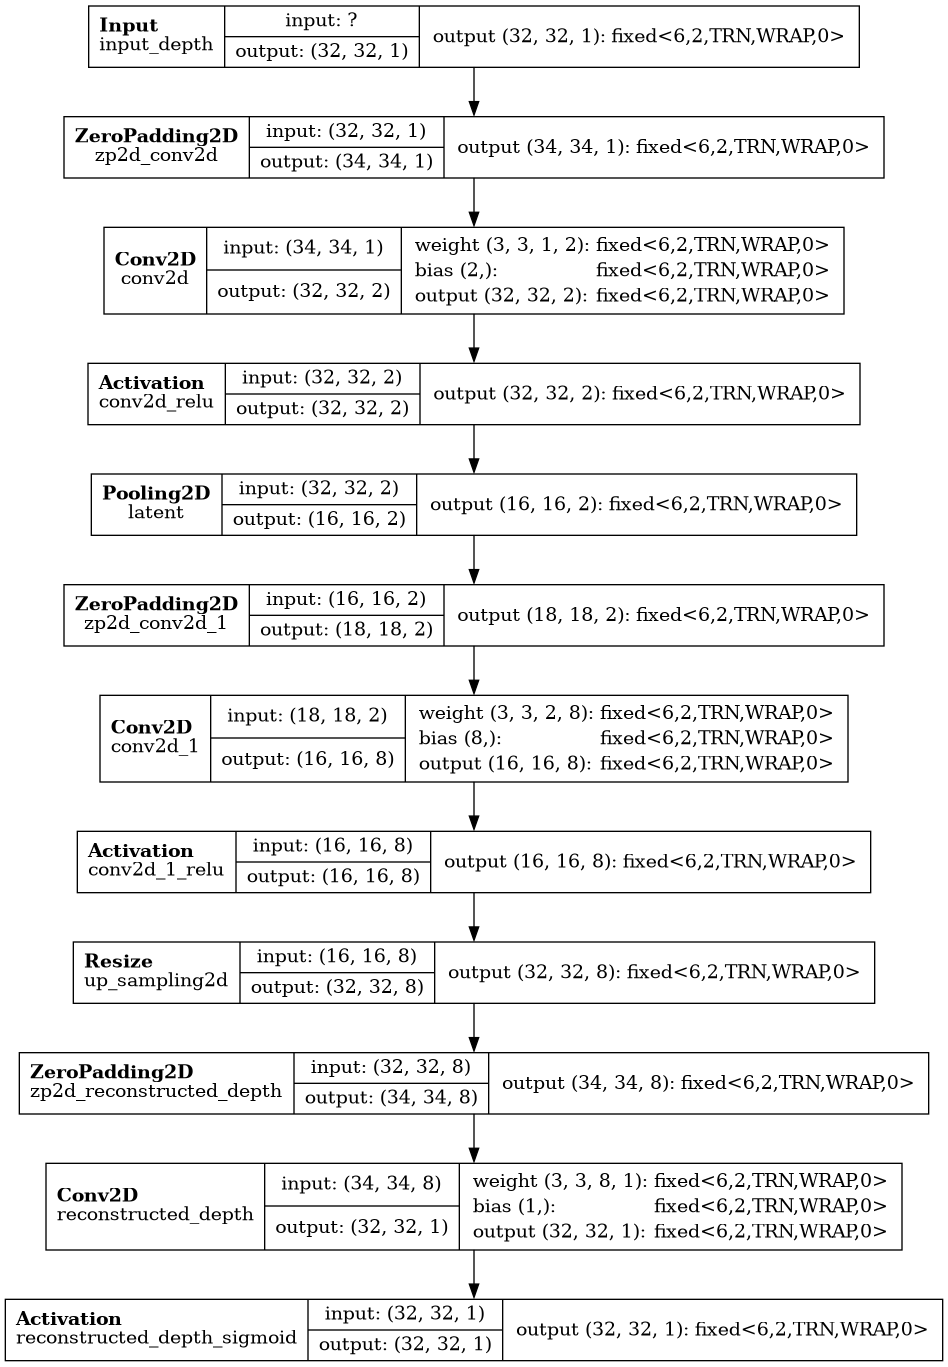

In [17]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [18]:
#import numpy as np

#X_test = np.load('X_test.npy')
#y_hls = hls_model.predict(np.ascontiguousarray(X_test))
#np.save('estimate_sign_example/y_hls.npy', y_hls)

In [19]:
hls_model.build(csim=False, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jeanleo2' on host 'administrateur-ThinkStation-P2-Tower' (Linux_x86_64 version 6.11.0-25-generic) on Wed May 21 15:44:38 CEST 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design 

INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_resource.h:82) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' (firmware/nnet_utils/nnet_dense_resource.h:82) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config8_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2,

INFO: [HLS 200-489] Unrolling loop 'ReLUPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:49) in function 'nnet::relu<nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, relu_config6>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ReLUPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:49) in function 'nnet::relu<nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 2u>, nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 2u>, relu_config3>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:228) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 2u>, nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 2u>, config4>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:236) in functi

INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.10' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V' (firmware/nnet_utils/nnet_padding_stream.h:10) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.9' (firmware/nnet_utils/nnet_padding_stream.h:10) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.11' (firmware/nnet_utils/nnet_padding_stream.h:10) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.12' (firmware/nnet_utils/nnet_padding_stream.h:10) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V' (firmware/nnet_utils/nnet_image_stream.h:19) in dimension 1 automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.0' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.1' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.

INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_resource.h:82) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' (firmware/nnet_utils/nnet_dense_resource.h:82) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, config8_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<6, 2,

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:41:61) to (firmware/nnet_utils/nnet_activation_stream.h:41:55) in function 'nnet::relu<nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, relu_config6>'... converting 25 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:41:61) to (firmware/nnet_utils/nnet_activation_stream.h:41:55) in function 'nnet::relu<nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 2u>, nnet::array<ap_fixed<6, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, 2u>, relu_config3>'... converting 7 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/myproject_axi.cpp:30:26) to (firmware/myproject_axi.cpp:29:53) in function 'Loop_2_proc'... converting 10 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperbloc

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:00:32 ; elapsed = 00:00:32 . Memory (MB): peak = 1650.703 ; gain = 1196.160 ; free physical = 1307 ; free virtual = 11410
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_axi' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc298' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 32.6 seconds; current allocated memory: 460.626 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.02 seconds; current allocated memory: 463.058 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_2u_array_ap_fixed_6_2_5_3_0_2u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.07 seconds; current allocated memory: 463.186 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.

INFO: [SCHED 204-61] Pipelining loop 'ImageHeight'.
   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:57) and fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:57).
   between fifo write on port 'resized_V_d

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.02 seconds; current allocated memory: 479.687 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.36 seconds; current allocated memory: 480.033 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-archite

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_ap_fixed_2u_array_ap_fixed_6_2_5_3_0_2u_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_ap_fixed_2u_array_ap_fixed_6_2_5_3_0_2u_config11_s'.
INFO: [HLS 200-111]  Elapsed time: 0.13 seconds; current allocated memory: 495.729 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_6_2_5_3_0_2u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_6_2_5_3_0_2u_config5_s_line_buffer_Array_V_1_0_0' to 'shift_line_buffer_array_ap_fixed_6_2_5_3_0_2u_config5_s_line_buffer_Array_V_1eOg' due to the l

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_6_2_5_3_0_config8_mult_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_6_2_5_3_0_config8_mult_0_0'.
INFO: [HLS 200-111]  Elapsed time: 0.23 seconds; current allocated memory: 542.012 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_6_2_5_3_0_1u_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_6_2_5_3_0_1u_config8_s'.
INFO: [HLS 200-111]  Elapsed time: 0.72 seconds; current allocated memory: 556.89

INFO: [HLS 200-790] **** Loop Constraint Status: All loop constraints were satisfied.
INFO: [HLS 200-789] **** Estimated Fmax: 225.78 MHz
INFO: [RTMG 210-286] Generating pipelined shifter : 'myproject_axi_ashr_54ns_32ns_54_2_1'
INFO: [RTMG 210-279] Implementing memory 'sigmoid_array_array_ap_fixed_6_2_5_3_0_1u_sigmoid_config9_s_sigmoid_table1_rom' using auto ROMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_0_V_U(fifo_w6_d1156_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_0_V_U(fifo_w6_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_1_V_U(fifo_w6_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_0_V_U(fifo_w6_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_1_V_U(fifo_w6_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_0_V_U(fifo_w6_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing

INFO: [IP_Flow 19-1686] Generating 'Synthesis' target for IP 'myproject_axi_ap_fpext_1_no_dsp_32'...
INFO: [IP_Flow 19-1686] Generating 'Simulation' target for IP 'myproject_axi_ap_fpext_1_no_dsp_32'...
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1704] No user IP repositories specified
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/tools/Xilinx/Vivado/2020.1/data/ip'.
INFO: [Common 17-206] Exiting Vivado at Wed May 21 15:45:35 2025...
***** EXPORT IP COMPLETED IN 0h0m19s *****
INFO: [HLS 200-112] Total elapsed time: 66.67 seconds; peak allocated memory: 569.156 MB.
INFO: [Common 17-206] Exiting vivado_hls at Wed May 21 15:45:45 2025...
Vivado synthesis report not found.
Cosim report not found.
Timing report not found.

****** Vivado v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source design.tcl
# set tcldir [fil

VHDL Output written to : /home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/synth/design_1.v
VHDL Output written to : /home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/sim/design_1.v
VHDL Output written to : /home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hdl/design_1_wrapper.v
INFO: [BD 41-1029] Generation completed for the IP Integrator block processing_system7_0 .
INFO: [BD 41-1029] Generation completed for the IP Integrator block ps7_0_axi_periph/s00_couplers/auto_pc .
INFO: [BD 41-1029] Generation completed for the IP Integrator block rst_ps7_0_100M .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/xbar .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s00_couplers/auto_us .
IN


****** Vivado v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source design_1_wrapper.tcl -notrace
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1700] Loaded user IP repository '/home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_prj'.
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/tools/Xilinx/Vivado/2020.1/data/ip'.
Command: link_design -top design_1_wrapper -part xc7z020clg400-1
Design is defaulting to srcset: sources_1
Design is defaulting to constrset: constrs_1
INFO: [Device 21-403] Loading part xc7z020clg400-1
INFO: [Project 1-454] Reading design checkpoint '/home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_processing_system7_0_0/design_1_processing_system7_0_0.dcp' for cell 'design_1_i/processing_sys

Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00 . Memory (MB): peak = 2334.945 ; gain = 0.000 ; free physical = 5546 ; free virtual = 10536
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 6 instances were transformed.
  RAM32M => RAM32M (RAMD32(x6), RAMS32(x2)): 5 instances
  RAM32X1D => RAM32X1D (RAMD32(x2)): 1 instance 

19 Infos, 3 Warnings, 0 Critical Warnings and 0 Errors encountered.
link_design completed successfully
link_design: Time (s): cpu = 00:00:08 ; elapsed = 00:00:10 . Memory (MB): peak = 2334.945 ; gain = 206.129 ; free physical = 5546 ; free virtual = 10536
Command: opt_design
Attempting to get a license for feature 'Implementation' and/or device 'xc7z020'
INFO: [Common 17-349] Got license for feature 'Implementation' and/or device 'xc7z020'
Running DRC as a precondition to command opt_design

Starting DRC Task
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Project 1-461] DRC finished with 0 Errors
INFO: [Project 1-462]

INFO: [Common 17-1381] The checkpoint '/home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_opt.dcp' has been generated.
INFO: [runtcl-4] Executing : report_drc -file design_1_wrapper_drc_opted.rpt -pb design_1_wrapper_drc_opted.pb -rpx design_1_wrapper_drc_opted.rpx
Command: report_drc -file design_1_wrapper_drc_opted.rpt -pb design_1_wrapper_drc_opted.pb -rpx design_1_wrapper_drc_opted.rpx
INFO: [IP_Flow 19-1839] IP Catalog is up to date.
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Coretcl 2-168] The results of DRC are in file /home/jeanleo2/hls4ml2/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_drc_opted.rpt.
report_drc completed successfully
Command: place_design
Attempting to get a license for feature 'Implementation' and/or device 'xc7z020'
INFO: [Common 17-349] Got license for feature 'Implementation' and/or device 'xc7z020'
INFO: [DRC 

Phase 3.6 Small Shape Detail Placement | Checksum: 14e77bac0

Time (s): cpu = 00:00:35 ; elapsed = 00:00:13 . Memory (MB): peak = 3213.996 ; gain = 0.000 ; free physical = 3818 ; free virtual = 9811

Phase 3.7 Re-assign LUT pins
Phase 3.7 Re-assign LUT pins | Checksum: ccbcde74

Time (s): cpu = 00:00:36 ; elapsed = 00:00:13 . Memory (MB): peak = 3213.996 ; gain = 0.000 ; free physical = 3818 ; free virtual = 9811

Phase 3.8 Pipeline Register Optimization
Phase 3.8 Pipeline Register Optimization | Checksum: 149e29a75

Time (s): cpu = 00:00:36 ; elapsed = 00:00:13 . Memory (MB): peak = 3213.996 ; gain = 0.000 ; free physical = 3818 ; free virtual = 9811

Phase 3.9 Fast Optimization
Phase 3.9 Fast Optimization | Checksum: 6cc09549

Time (s): cpu = 00:00:38 ; elapsed = 00:00:14 . Memory (MB): peak = 3213.996 ; gain = 0.000 ; free physical = 3820 ; free virtual = 9813
Phase 3 Detail Placement | Checksum: 6cc09549

Time (s): cpu = 00:00:38 ; elapsed = 00:00:14 . Memory (MB): peak = 3213.996 

 Number of Nodes with overlaps = 0

Phase 2.4 Update Timing
Phase 2.4 Update Timing | Checksum: 15eeedbd4

Time (s): cpu = 00:00:14 ; elapsed = 00:00:09 . Memory (MB): peak = 3213.996 ; gain = 0.000 ; free physical = 3517 ; free virtual = 9528
INFO: [Route 35-416] Intermediate Timing Summary | WNS=0.768  | TNS=0.000  | WHS=-0.283 | THS=-252.891|

Phase 2 Router Initialization | Checksum: 21ae3d1ee

Time (s): cpu = 00:00:16 ; elapsed = 00:00:10 . Memory (MB): peak = 3213.996 ; gain = 0.000 ; free physical = 3516 ; free virtual = 9528

Router Utilization Summary
  Global Vertical Routing Utilization    = 0 %
  Global Horizontal Routing Utilization  = 0 %
  Routable Net Status*
  *Does not include unroutable nets such as driverless and loadless.
  Run report_route_status for detailed report.
  Number of Failed Nets               = 16844
    (Failed Nets is the sum of unrouted and partially routed nets)
  Number of Unrouted Nets             = 16844
  Number of Partially Routed Nets     = 0

Resolution: To review and fix problems, please run Power Constraints Advisor in the GUI from Tools > Power Constraints Advisor or run report_power with the -advisory option to generate a text report.
118 Infos, 4 Warnings, 0 Critical Warnings and 0 Errors encountered.
report_power completed successfully
INFO: [runtcl-4] Executing : report_route_status -file design_1_wrapper_route_status.rpt -pb design_1_wrapper_route_status.pb
INFO: [runtcl-4] Executing : report_timing_summary -max_paths 10 -file design_1_wrapper_timing_summary_routed.rpt -pb design_1_wrapper_timing_summary_routed.pb -rpx design_1_wrapper_timing_summary_routed.rpx -warn_on_violation 
INFO: [Timing 38-91] UpdateTimingParams: Speed grade: -1, Delay Type: min_max.
INFO: [Timing 38-191] Multithreading enabled for timing update using a maximum of 8 CPUs
INFO: [runtcl-4] Executing : report_incremental_reuse -file design_1_wrapper_incremental_reuse_routed.rpt
INFO: [Vivado_Tcl 4-1062] Incremental flow is disabled. No incremen

Netlist sorting complete. Time (s): cpu = 00:00:00.11 ; elapsed = 00:00:00.11 . Memory (MB): peak = 2404.398 ; gain = 0.000 ; free physical = 4874 ; free virtual = 10925
INFO: [Netlist 29-17] Analyzing 781 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-479] Netlist was created with Vivado 2020.1
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Timing 38-478] Restoring timing data from binary archive.
INFO: [Timing 38-479] Binary timing data restore complete.
INFO: [Project 1-856] Restoring constraints from binary archive.
INFO: [Project 1-853] Binary constraint restore complete.
Reading XDEF placement.
Reading placer database...
Reading XDEF routing.
Read XDEF File: Time (s): cpu = 00:00:00.71 ; elapsed = 00:00:00.75 . Memory (MB): peak = 2812.871 ; gain = 9.938 ; free physical = 4294 ; free virtual = 10345
Restored from archive | CPU: 0.760000 secs | Memory: 21.581207 MB |
Finished XDEF File 

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.429',
  'BestLatency': '13962',
  'WorstLatency': '13965',
  'IntervalMin': '11266',
  'IntervalMax': '13874',
  'BRAM_18K': '45',
  'DSP': '0',
  'FF': '9459',
  'LUT': '15674',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.684,
  'TNS': 0.0,
  'WHS': 0.017,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [ ]:
!sed -n '30,45p' estimate_sign_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt

In [ ]:
!mkdir -p estimate_sign_example/hls4ml_prj_pynq/package
!cp estimate_sign_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit estimate_sign_example/hls4ml_prj_pynq/package/hls4ml_nn.bit
!cp estimate_sign_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh estimate_sign_example/hls4ml_prj_pynq/package/hls4ml_nn.hwh
!cp estimate_sign_example/hls4ml_prj_pynq/axi_stream_driver.py estimate_sign_example/hls4ml_prj_pynq/package/
np.save('estimate_depth_example/hls4ml_prj_pynq/package/X_test.npy', X_test)
np.save('estimate_depth_example/hls4ml_prj_pynq/package/y_test.npy', y_test)
#!cp X_test.npy y_test.npy estimate_sign_example/hls4ml_prj_pynq/package
!cp part7b_deployment.ipynb estimate_sign_example/hls4ml_prj_pynq/package

!tar -czvf estimate_sign_example/hls4ml_prj_pynq/package.tar.gz -C estimate_sign_example/hls4ml_prj_pynq/package/ .